# Tracking Juputer's Moons

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
import pandas as pd
import os
from scipy.ndimage import label, binary_dilation, gaussian_filter
from astropy.stats import sigma_clipped_stats
from skimage import measure
import cv2
from PIL import Image
import glob
from datetime import datetime

In [22]:
import dill
def safe_dump_session(filename='tidy.pkl'):
    bad_vars = []
    for name, val in globals().items():
        try:
            dill.dumps(val)
        except:
            bad_vars.append(name)
    for name in bad_vars:
        del globals()[name]
    dill.dump_session(filename)

# 1. Data Exploration and Visualization

### Looking at the fits files

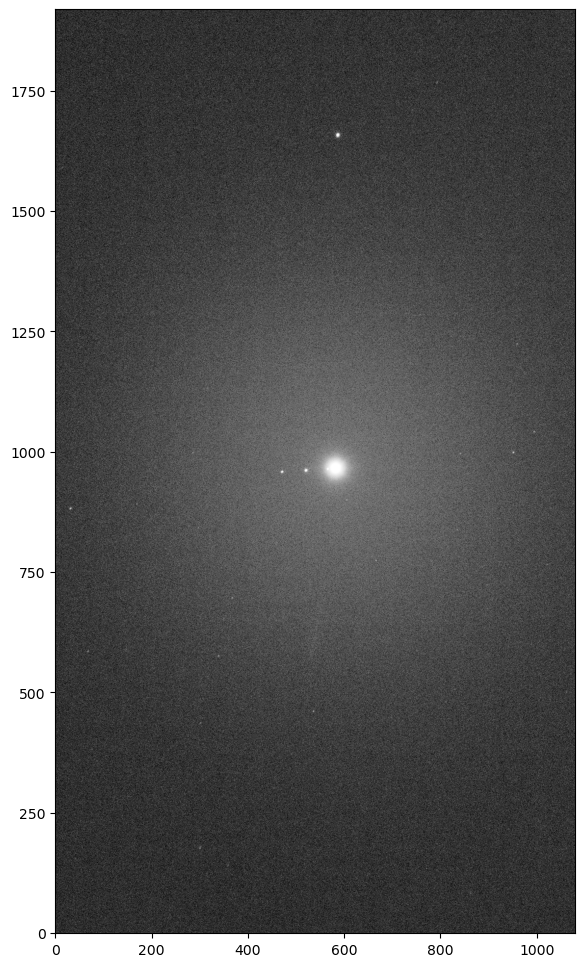

In [7]:
# Extract the file paths
fits_dir = r'C:\Users\willi\Box\Jupiter\data\Jupiter_stacked'
fits_filenames = [os.path.join(fits_dir, f) for f in os.listdir(fits_dir) if f.endswith('.fit')]

# Extract the image data from the fits files
fits_images = []
for fits_file in fits_filenames:
    with fits.open(fits_file) as hdul:
        image_data = hdul[0].data.copy()
        image_header = hdul[0].header.copy()
        fits_images.append([image_data, image_header])

# Display an example image
fig = plt.figure(figsize = (10,12))
plt.imshow(apply_stretch(fits_images[0][0]), cmap='gray', origin='lower')

# 2. Physical Context and Research

# 3. Data Processing and Feature Extraction

### Extracting the video frames

In [8]:
# List of video files
video_files = [

    r'C:\Users\willi\Box\Jupiter\data\2025-04-27-213422\2025-04-27-213422-Jupiter-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-27-215412\2025-04-27-215412-Jupiter-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-27-215454\2025-04-27-215454-Jupiter-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-27-221935\2025-04-27-221935-Jupiter-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-28-204005\2025-04-28-204005-Unknown-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-28-204205\2025-04-28-204205-Unknown-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-28-204343\2025-04-28-204343-Unknown-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-28-220346\2025-04-28-220346-Jupiter-timelapse-RAW.avi',
    r'C:\Users\willi\Box\Jupiter\data\2025-04-28-220612\2025-04-28-220612-Jupiter-RAW.avi',
]

# Create a directory to save the frames
output_dir = r'C:\Users\willi\Box\Jupiter\data\frames'
os.makedirs(output_dir, exist_ok=True)

# Extract frames
for video_file in video_files:
    # Open the video file
    cap = cv2.VideoCapture(video_file)

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Save the frame as an image (e.g., frame_001.jpg, frame_002.jpg)
        frame_filename = os.path.join(output_dir, f'{video_file.split("\\")[-1].split(".")[0]}_frame_{frame_count:04d}.jpg')
        cv2.imwrite(frame_filename, frame)
        
        frame_count += 1

    cap.release()

In [9]:
def extract_time_info(file):
    '''
    Input: 
    - file: full filename (\directory\file) of a video frame jpg
    Ex. '2025-04-27-213422-Jupiter-timelapse-RAW_frame_0000.jpg'

    Returns:
    - timestamp: datetime object with the time the video was recorded
    - frame_num: 4-digit number describing which video frame the jpg is.
    '''
    
    basename = os.path.basename(file) # Extracts the file name from the full file directory/name
    dt_str = basename[:17] # Extract a datetime string to pass through datetime.strptime
    timestamp = datetime.strptime(dt_str, '%Y-%m-%d-%H%M%S')
    frame_num = basename[-8:-4]
    return timestamp, frame_num

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\willi\AppData\Local\Temp\ipykernel_20796\2721300841.py:2: SyntaxWarning: invalid escape sequence '\d'
  '''


In [10]:
# Extract frames to list

frames_dir = r'C:\Users\willi\Box\Jupiter\data\frames'
frame_files = sorted(glob.glob(os.path.join(frames_dir, '*.jpg')))

frames = []

for file in frame_files:
    image_data = np.array(Image.open(file).convert('L'))  # Convert to grayscale
    timestamp, frame_num = extract_time_info(file)  # Extract the timestamp per video
    frames.append([image_data, timestamp, frame_num, file])

### Enhancing the video frames

In [11]:
def enhance_image(image, sigma=1.5):
    '''
    A function to enhance the jpg frames, making the moons easier to spot by a moon-finding algorithm.
    Applies a highpass gaussian filter using scipy.ndimage followed by high contrast from cv2.
    '''
    blurred = gaussian_filter(image, sigma=sigma)
    filtered = np.clip(image - blurred, 0, 255)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(20, 20)) # Set up high contrast function
    return clahe.apply(filtered)

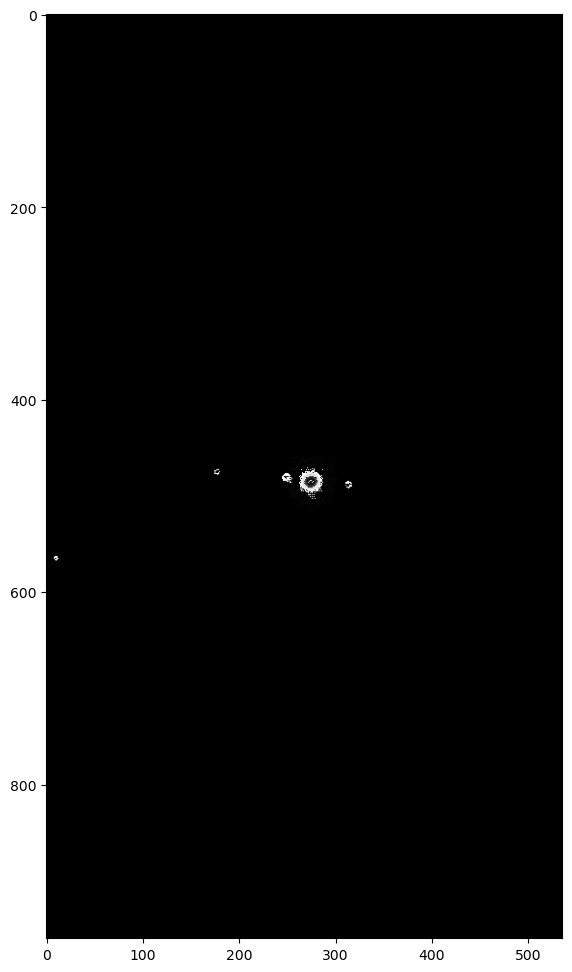

In [12]:
# Example usage:

enhanced_frame = enhance_image(frames[0][0])

plt.figure(figsize=(12,12))
plt.imshow(enhanced_frame, cmap='gray')

 # Later make subplot with before and after

In [13]:
# Create a directory to save the enhanced frames
enhanced_frames_dir = r'C:\Users\willi\Box\Jupiter\data\enhanced_frames'
os.makedirs(output_dir, exist_ok=True)

# Enhance the frames using the function and save them
enhanced_frames = []
for frame in frames:
    enhanced_image_data = enhance_image(frame[0])
    enhanced_filename = os.path.join(enhanced_frames_dir, f'ENHANCED_{os.path.basename(frame[3])}')
    cv2.imwrite(enhanced_filename, enhanced_image_data)
    # Added to the enhanced_frames list:
    # 1. the enhanced image data
    # 2. The source video's timestamp
    # 3. The source video's frame number
    # 4. The new filename
    enhanced_frames.append([enhanced_image_data, frame[1], frame[2], enhanced_filename])

### Developing a moon-finding algorithm

In [14]:
def weighted_centroid(region_mask, image):
    '''
    This function is used below to calculate the weighted average position for each centroid in the binary image. 
    This helps in making sure the centroids are actually in the middle of the moons since they are rather large.
    '''
    y_indices, x_indices = np.nonzero(region_mask)
    intensities = image[y_indices, x_indices]
    total_intensity = np.sum(intensities)
    x_center = np.sum(x_indices * intensities) / total_intensity
    y_center = np.sum(y_indices * intensities) / total_intensity
    return np.array([y_center, x_center])


def detect_bright_regions(channel_data, sigma_threshold=30.0, plot_labeled_image=False, dilation_iterations=1):
    """
    Detects the brightest regions in a 2D image using a thresholding approach with sigma-clipped statistics,
    binary dilation, and region labeling. Works for both fits and jpg images.

    Parameters:
    - channel_data : 2D numpy array (image data).
    - sigma_threshold : Determines how many stdvs above median brightness to be included in the binary image.
    (AKA The number of standard deviations for the sigma-clipped thresholding. Default is 30).
    - plot_labeled_image : If True, will plot the sigma thresholded regions
    - dilation_iterations : Number of iterations for binary dilation (default is 1).

    Returns:
    - List of centroids of the 5 brightest regions.
    """
    # Step 1: Compute sigma-clipped statistics (mean, median, std dev)
    mean, median, std = sigma_clipped_stats(channel_data, sigma=sigma_threshold)
    
    # Step 2: Create a binary mask using the median + sigma * std
    binary = channel_data > (median + sigma_threshold * std)
    
    # Step 3: Apply binary dilation to merge small regions
    dilated_image = binary_dilation(binary, iterations=dilation_iterations)
    
    # Step 4: Label the connected components in the binary image
    labeled_image, num_features = label(dilated_image)

    if plot_labeled_image:
        # Get boundaries of each labeled region
        contours = measure.find_contours(labeled_image, level=0.5)

        plt.figure(figsize=(12, 12))
        plt.imshow(channel_data, cmap='gray', origin='lower')

        # Plot each contour
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='lime')

        plt.title('Bright Region Contours on Image')
        plt.show()

    # Step 5: Get the properties of the labeled regions (flux and centroid)
    region_properties = []
    for region_id in range(1, num_features + 1):
        region_mask = (labeled_image == region_id)
        region_flux = np.sum(channel_data[region_mask])  # Sum the pixel intensities (flux)
        region_center = weighted_centroid(region_mask, channel_data)  # Get the weighted centroid
        region_properties.append((region_flux, region_center))

    # Step 6: Sort the regions by flux (brightest first) and select the top 5
    region_properties.sort(reverse=True, key=lambda x: x[0])
    top_5_regions = region_properties[:5]
    
    return top_5_regions

### Visualizing Detections

In [ ]:
def plot_detections(input_image, image_type):
    '''
    A function to plot the detected moons.
    Calls detect_bright_regions to detect the moons and plots them with WCS (for Fits images).

    Inputs: 
    - input_image: image object with image data and metadata
    - image_type: 'fits' or 'jpg' image
    '''

    # Detect the top 5 brightest regions (moons) with the updated approach
    regions = detect_bright_regions(input_image[0], plot_labeled_image=True)

    # Output the coordinates of the 5 brightest regions (moons)
    print(f"Detected {len(regions)} regions.")
    for i, (flux, center) in enumerate(regions, start=1):
        print(f"Moon {i}: Centroid at {center}, Flux: {flux}")

    # Plot the image with detected regions
    plt.figure(figsize=(12, 12))

    if image_type == 'fits':
        # Project the WCS coordinates from the fits header, show the image
        wcs = WCS(input_image[1], naxis=2)
        ax = plt.subplot(projection=wcs) # Project the sky coordinates of the image stored in wcs
        plt.imshow(apply_stretch(input_image[0]), cmap='gray', origin='lower')
        ax.coords.grid(color='white', ls='solid')

    elif image_type == 'jpg':
        # Just show the image
        plt.imshow(input_image[0], cmap='gray', origin='lower')

    else: 
        print('Incorrect image type!')
        
    # Plot the centroids
    for flux, center in regions:
        plt.scatter(center[1], center[0], edgecolor='red', facecolors='none', s=100)  

    # Title, label axes, and show the plot
    plt.title("Detected Moons")
    plt.xlabel('Right Ascension (RA)')
    plt.ylabel('Declination (Dec)')
    plt.show()

<>:22: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\willi\AppData\Local\Temp\ipykernel_20796\3013996748.py:22: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if image_type is 'fits':
C:\Users\willi\AppData\Local\Temp\ipykernel_20796\3013996748.py:29: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif image_type is 'jpg':


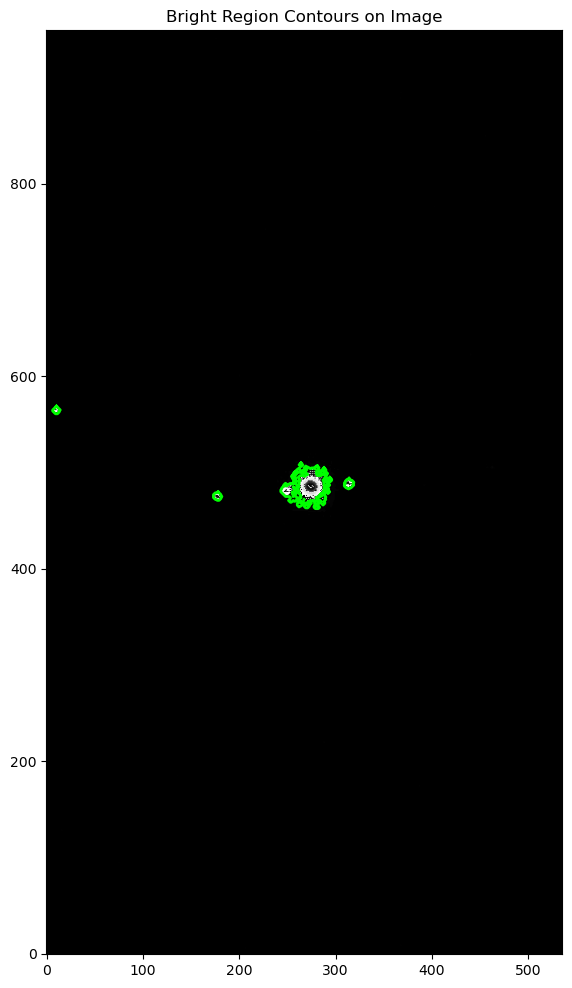

Detected 5 regions.
Moon 1: Centroid at [485.57568215 274.79897149], Flux: 85172
Moon 2: Centroid at [481.14922968 249.88345259], Flux: 15513
Moon 3: Centroid at [488.09430398 314.06698634], Flux: 6882
Moon 4: Centroid at [475.44935452 177.15193644], Flux: 4028
Moon 5: Centroid at [564.63909165   9.92619627], Flux: 3699


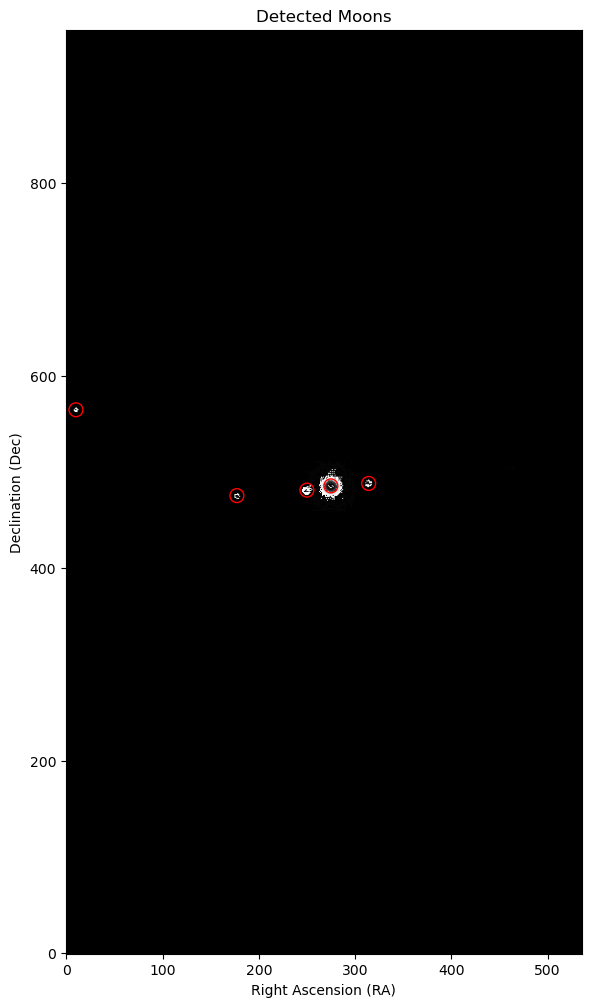

In [16]:
plot_detections(enhanced_frames[0], image_type='jpg')

### Tracking the fits images over time

In [17]:
# Initialize an empty list to store results
fits_tracking_data = []

# Loop over all images
for image_data, image_header in tqdm(fits_images):

    # Step 1: Detect bright regions
    regions = detect_bright_regions(image_data)

    # Step 2: Set up WCS from the header
    wcs = WCS(image_header, naxis=2)

    # Step 3: Get observation time
    obs_time = image_header.get('DATE-OBS', None)

    # Step 4: For each region, convert pixel to WCS and save info
    for i, (flux, center) in enumerate(regions):
        ra, dec = wcs.all_pix2world(center[1], center[0], 0)  # x, y → RA, Dec

        fits_tracking_data.append({
            'obs_time': obs_time,
            'region_id': i + 1,
            'flux': flux,
            'pixel_x': center[1],
            'pixel_y': center[0],
            'ra': ra,
            'dec': dec
        })

# Step 5: Create a DataFrame
df = pd.DataFrame(fits_tracking_data)
df['obs_time'] = pd.to_datetime(df['obs_time'])  # Convert to datetime if available


# Individual dfs
df_region1 = df[df['region_id'] == 1]  # Likely Jupiter
df_region2 = df[df['region_id'] == 2]  # Likely Ganymede or Io
df_region3 = df[df['region_id'] == 3]
df_region4 = df[df['region_id'] == 4]

# Example
df_region2

100%|██████████| 10/10 [00:01<00:00,  5.11it/s]


,obs_time,region_id,flux,pixel_x,pixel_y,ra,dec
1,2025-04-29 01:56:57.482245,2,960756,586.919707,1658.004517,587.9197069807526,1659.0045172759785
5,2025-04-29 01:56:46.348055,2,1170480,587.307279,1658.277930,588.307279064999,1659.2779304217074
10,2025-04-29 01:57:08.824893,2,1017488,587.766696,1657.439751,588.7666960200022,1658.4397506407938
14,2025-04-29 01:57:20.159346,2,996229,588.335379,1657.196969,589.3353787131272,1658.1969687692288
18,2025-04-29 01:59:59.132253,2,968451,569.242583,1660.226545,570.242583259246,1661.2265452769423
22,2025-04-29 02:00:10.450381,2,908390,568.747687,1660.198817,569.7476865663426,1661.1988165875891
26,2025-04-29 02:00:21.784205,2,949091,568.062380,1660.042039,569.0623796875116,1661.0420391722184
30,2025-04-29 02:00:33.100133,2,953920,567.256038,1659.980657,568.2560382422006,1660.9806566588393
34,2025-04-29 02:00:44.422977,2,981152,566.016888,1660.154637,567.0168883108836,1661.154636590457
38,2025-04-29 02:00:55.754160,2,1055651,564.637357,1660.381296,565.6373574221026,1661.3812964701401


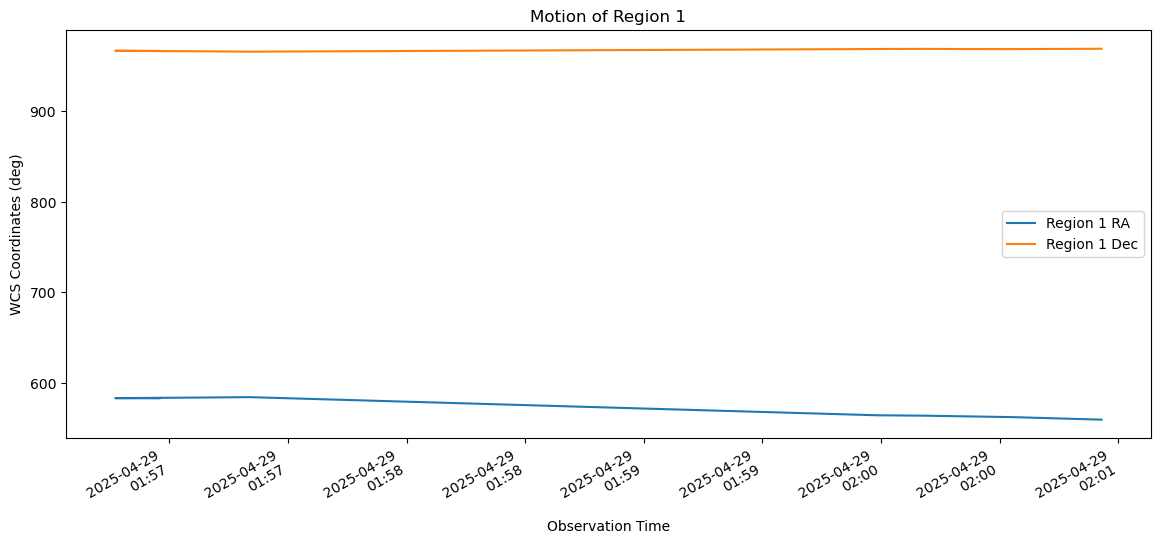

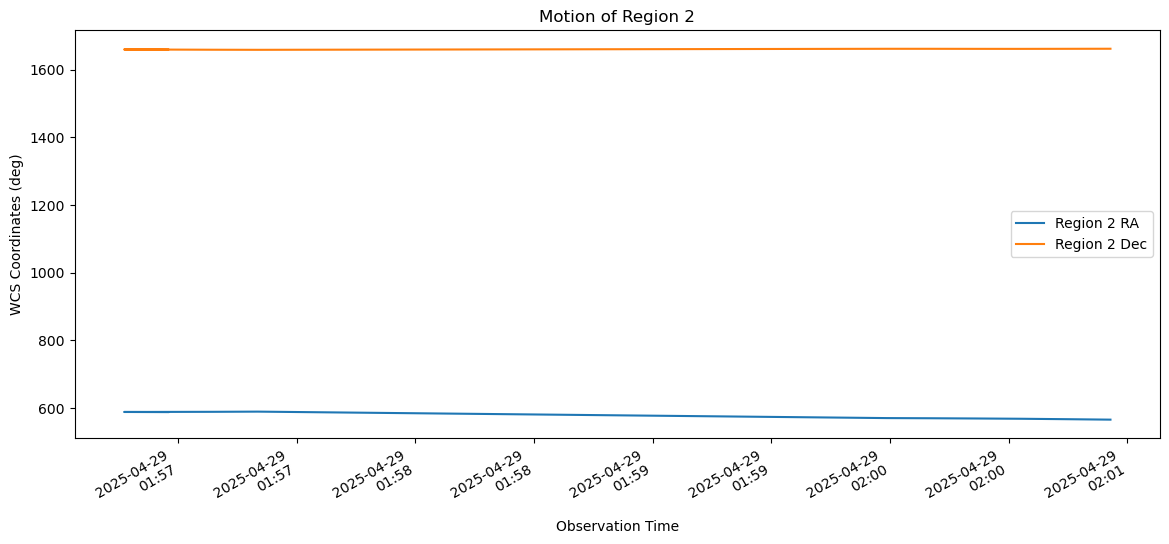

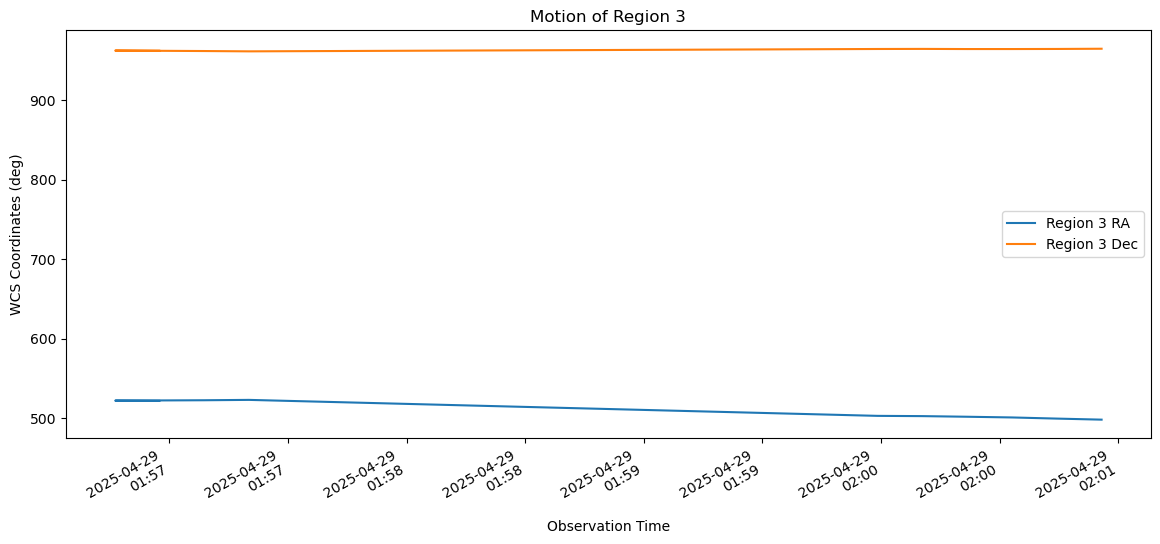

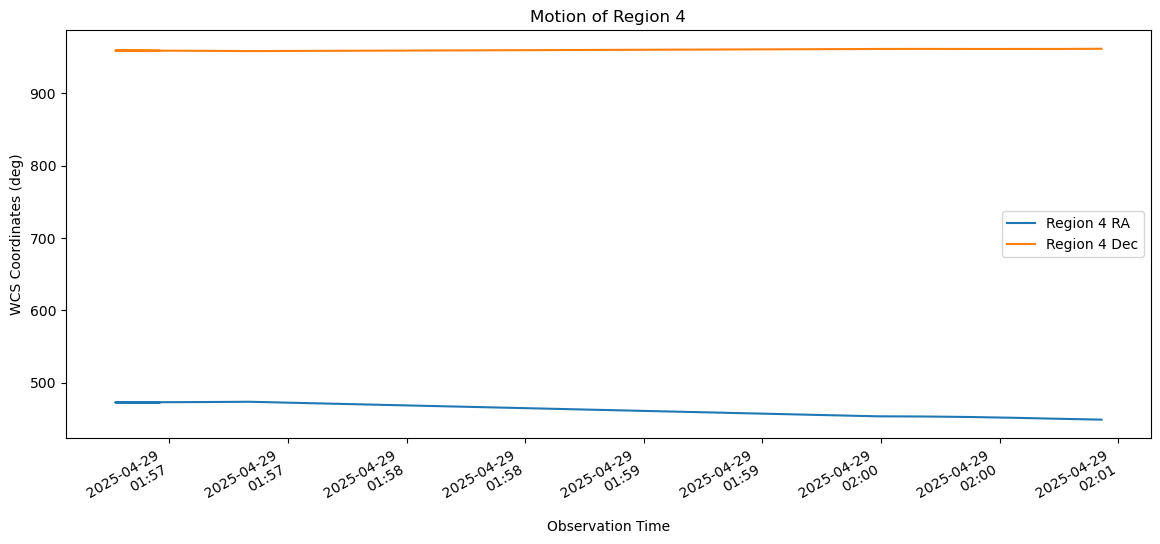

In [18]:
# Plotting moons/jupyter over time based on limited fits data

for df_region in [df_region1, df_region2, df_region3, df_region4]:

    plt.figure(figsize=(14, 6))  # Wider and slightly shorter

    region_id = df_region['region_id'].iloc[0]
    plt.plot(df_region['obs_time'], df_region['ra'],  label=f'Region {region_id} RA')
    plt.plot(df_region['obs_time'], df_region['dec'], label=f'Region {region_id} Dec')
    plt.xlabel("Observation Time")
    plt.ylabel("WCS Coordinates (deg)")
    plt.legend()
    plt.title(f"Motion of Region {region_id}")

    # Fix the time axis
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))  # Adjust format if needed
    plt.gcf().autofmt_xdate()  # Auto-rotate for better readability

    plt.show()

In [19]:
df

,obs_time,region_id,flux,pixel_x,pixel_y,ra,dec
0,2025-04-29 01:56:57.482245,1,29589603,582.007416,965.791500,583.0074158480598,966.7914997710513
1,2025-04-29 01:56:57.482245,2,960756,586.919707,1658.004517,587.9197069807526,1659.0045172759785
2,2025-04-29 01:56:57.482245,3,738766,520.904523,961.019926,521.904523218448,962.0199264719816
3,2025-04-29 01:56:57.482245,4,312328,471.097247,957.870550,472.0972471248175,958.8705495504726
4,2025-04-29 01:56:46.348055,1,28106640,582.190477,965.946937,583.1904774103201,966.9469369515531
5,2025-04-29 01:56:46.348055,2,1170480,587.307279,1658.277930,588.307279064999,1659.2779304217074
6,2025-04-29 01:56:46.348055,3,857776,521.313219,961.217959,522.3132193020089,962.2179590009513
7,2025-04-29 01:56:46.348055,4,338992,471.607731,958.014396,472.6077311558975,959.0143956199556
8,2025-04-29 01:56:46.348055,5,52864,359.995763,1771.004540,360.9957627118644,1772.0045399515739
9,2025-04-29 01:57:08.824893,1,29381726,582.860762,965.371624,583.8607622642727,966.3716244239702
